In [1]:
import warnings

from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

# %%
import SpaCross as TOOLS

section_ids = ['E9.5_E1S1', 'E10.5_E2S1', 'E11.5_E1S1']
def load_data(k_cutoff, n_top_genes):
    Batch_list = []
    for slice_id, proj_name in enumerate(section_ids):
        adata = sc.read_h5ad(os.path.join(r"C:\Users\DELL\datasets\MouseEmbryo/" + proj_name + ".MOSTA.h5ad"))
        adata.var_names_make_unique()
        adata.obs_names = [x + '_' + proj_name for x in adata.obs_names]
        ##### Load layer_guess label, if have
        adata.obs['layer_guess'] = adata.obs['annotation']
        adata.obs['slice_id'] = slice_id

        adata.layers['count'] = adata.X
        sc.pp.filter_genes(adata, min_cells=50)
        sc.pp.filter_genes(adata, min_counts=10)
        sc.pp.normalize_total(adata, target_sum=1e6)
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=n_top_genes)
        adata = adata[:, adata.var['highly_variable'] == True]
        sc.pp.scale(adata)
        adata = adata[:, adata.var['highly_variable']]
        Batch_list.append(adata)

    adata, edge_index = TOOLS.graph_construction3D(Batch_list, section_ids=section_ids, k_cutoff=k_cutoff, rad_cutoff=None, mode='KNN', slice_dist_micron=[100, 100], coor_key='spatial')
    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, edge_index

In [2]:
# adata, edge_index = load_data(6, 10000)
adata, edge_index = load_data(8, 5000)

Start building a graph...
Radius for graph connection is 1.5000.
The graph contains 356248 edges, 44531 cells.
8.0000 neighbors per cell on average.


In [3]:

with open('../Config/ME3.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)


In [4]:
num_clusters = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = TOOLS.SC_BC_pipeline(adata, edge_index=edge_index, num_clusters=num_clusters, device=device, config=config, imputation=False)
# %%
net.trian()
# %%
enc_rep, recon = net.process()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
# %%

Epoch 299 total loss=1.638 recon loss=0.740 mean loss=0.386 tri loss=1.344: 100%|██████████| 300/300 [01:50<00:00,  2.72it/s]


In [5]:
# %%
clusType = 'mclust'
adata.obs[clusType] = TOOLS.clustering(z=enc_rep, n_clust=20, num_seed=1, method=clusType)
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs[clusType])

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


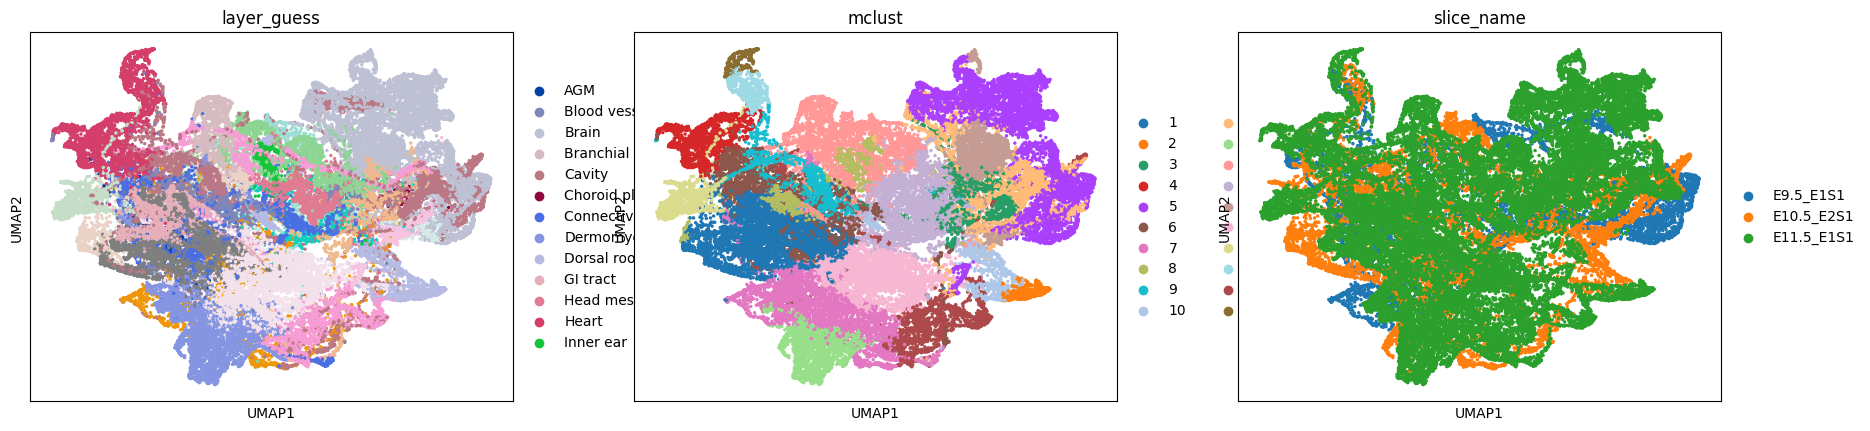

In [6]:
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', 'mclust', 'slice_name'], show=True, size=25, save=False)

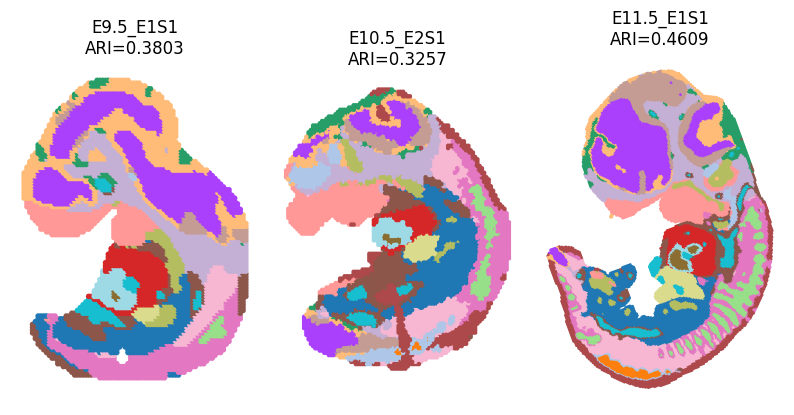

In [7]:
spot_size = 2
title_size = 12
fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx, name in enumerate(section_ids):
    sub_adata = adata[adata.obs['slice_name'] == name]
    sub_adata_tmp = sub_adata[~pd.isnull(sub_adata.obs['layer_guess'])]
    ARI = ari_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs["mclust"])
    _sc_ = sc.pl.spatial(sub_adata, img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                      spot_size=spot_size)
    _sc_[0].set_title(name + "\nARI=" + str(round(ARI, 4)), size=title_size)
plt.show()